In [1]:
from fifipy.fit import fitAllSlopes
from fifipy.io import readData

In [2]:
rootdir = '/Users/dfadda/sofia/FIFI-LS/SpectralFlats/'
caldir = 'calsource_flat_02_2018/'

In [3]:
from glob import glob as gb
directory = rootdir+caldir+'D105M1_1/'
files = gb(directory+'*.fits')

In [4]:
aor, hk, gratpos, flux = readData(files[0])

In [5]:
spectra = fitAllSlopes(flux)

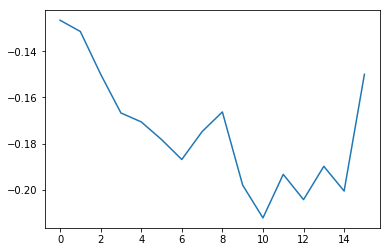

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(spectra[0,:,3])